In [ ]:
!pip install pyspark

In [ ]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark import SparkConf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [ ]:
conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "8g")

sc = SparkContext(conf=conf)
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("LDA Example") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

#spark = SparkSession(sc).builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [ ]:
import os
print(os.listdir('/content/drive'))


['MyDrive', '.shortcut-targets-by-id', '.file-revisions-by-id', '.Trash-0']


#### Importing Reviews Data

In [ ]:
file_path = "/content/drive/MyDrive/yelp_review.csv"
df_reviews = spark.read.format("csv").option("header", "true").option("multiline", "true").load(file_path)
#df_reviews = spark.read.format("csv").option("header", "true").option("multiline","true").load("yelp_review.csv")
df_reviews.printSchema()
df_reviews.show(1)


root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
only showing top 1 row



#### Importing users data

In [ ]:
file_path = "/content/drive/MyDrive/yelp_user.csv"
df_users = spark.read.format("csv").option("header", "true").option("multiline", "true").load(file_path)

#df_users = spark.read.format("csv").option("header", "true").option("multiline","true").load("yelp_user.csv")
df_users.printSchema()
df_users.show(5)


root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: string (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- friends: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- fans: string (nullable = true)
 |-- elite: string (nullable = true)
 |-- average_stars: string (nullable = true)
 |-- compliment_hot: string (nullable = true)
 |-- compliment_more: string (nullable = true)
 |-- compliment_profile: string (nullable = true)
 |-- compliment_cute: string (nullable = true)
 |-- compliment_list: string (nullable = true)
 |-- compliment_note: string (nullable = true)
 |-- compliment_plain: string (nullable = true)
 |-- compliment_cool: string (nullable = true)
 |-- compliment_funny: string (nullable = true)
 |-- compliment_writer: string (nullable = true)
 |-- compliment_photos: string (nullable = true)

+--------------------+------+--------

#### Identifying elite users for each year

In [ ]:
from pyspark.sql.functions import explode, split, col

# Find unique values of the "elite" column
unique_elite_values = df_users.select("elite").distinct()

# Show the unique values
unique_elite_values.show()

from pyspark.sql.functions import explode, split, col

# Split the values in the 'elite' column and explode them into separate rows
df2 = df_users.withColumn("elite_years", split(col("elite"), ",\s*")).select("user_id", explode("elite_years").alias("elite_year"))

# Group by 'elite_year' and count the occurrences
elite_users_by_year = df2.groupBy("elite_year").count().orderBy("elite_year")

# Show the results
elite_users_by_year.show()




+--------------------+
|               elite|
+--------------------+
|2015, 2014, 2013,...|
|2013, 2014, 2009,...|
|2012, 2009, 2015,...|
|2016, 2015, 2017,...|
|2013, 2017, 2014,...|
|2009, 2007, 2008,...|
|2015, 2016, 2010,...|
|2009, 2012, 2013,...|
|2011, 2008, 2009,...|
|          2017, 2010|
|2012, 2008, 2009,...|
|2016, 2015, 2012,...|
|2010, 2015, 2008,...|
|2013, 2015, 2011,...|
|2009, 2011, 2008,...|
|2012, 2017, 2013,...|
|2012, 2010, 2011,...|
|2013, 2010, 2011,...|
|2014, 2009, 2010,...|
|2011, 2017, 2010,...|
+--------------------+
only showing top 20 rows

+----------+-------+
|elite_year|  count|
+----------+-------+
|      2005|    140|
|      2006|    887|
|      2007|   2363|
|      2008|   3621|
|      2009|   6536|
|      2010|  10485|
|      2011|  13185|
|      2012|  17777|
|      2013|  19841|
|      2014|  20488|
|      2015|  26018|
|      2016|  30856|
|      2017|  34928|
|      None|1265282|
+----------+-------+



#### creating a flag for elite users

In [ ]:
from pyspark.sql.functions import when, col
# Add a new column 'elite_flag' with value 1 if 'elite' column is not None, otherwise 0
df_users = df_users.withColumn("elite_flag", when(col("elite") == "None", 0).otherwise(1))
df_users.show(5)

# Count the occurrences of each value in the "elite_flag" column
elite_flag_counts = df_users.groupBy("elite_flag").count()

# Show the counts
elite_flag_counts.show()

+--------------------+------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+----------+
|             user_id|  name|review_count|yelping_since|             friends|useful|funny|cool|fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|elite_flag|
+--------------------+------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+----------+
|JJ-aSuM4pCFPdkfoZ...| Chris|          10|   2013-09

#### Cleaning Reviews Data

In [ ]:
import string
from pyspark.sql.functions import lower, regexp_replace
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace

def clean_text(df, column_name, clean_column_name):
    # Create a new column called "clean_sentence"
    df = df.withColumn(clean_column_name, df[column_name])
    # Lowercase all letters
    df = df.withColumn(clean_column_name, lower(df[clean_column_name]))
    # Replace hyphens between words with a whitespace
    df = df.withColumn(clean_column_name, regexp_replace(df[clean_column_name], r'([a-z])-([a-z])', r'\1 \2'))
    # Remove periods between letters without whitespace and combine letters
    df = df.withColumn(clean_column_name, regexp_replace(df[clean_column_name], r'(\w)\.(\w)', r'\1\2'))
    # Remove apostrophes between letters without whitespace and combine letters
    df = df.withColumn(clean_column_name, regexp_replace(df[clean_column_name], r'(\w)\'(\w)', r'\1\2'))
    return df

def remove_punctuation(text):
    '''
    Removes all punctuation from text
    '''
    return text.translate(str.maketrans('', '', string.punctuation))



def remove_punctuation_in_dataframe_column(df, column_name):
    '''
    Removes all punctuation in a Spark DataFrame column
    '''
    return df.withColumn(column_name, regexp_replace(df[column_name], r'[!"#$%&\'()*+,\-./:;<=>?@[\\]^_`{|}~]', ''))




In [ ]:
df_reviews = clean_text(df_reviews, "text", "clean_text_column")
df_reviews = remove_punctuation_in_dataframe_column(df_reviews, "clean_text_column")
df_reviews.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|   clean_text_column|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+--------------------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|super simple plac...|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|small unassuming ...|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|leste12 is locate...|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|love coming here ...|
|L_9BT

#### Merging Reviews and Users Data

In [ ]:
# Select relevant columns from df_reviews
df_reviews_selected = df_reviews.select("user_id", "clean_text_column")

# Select relevant columns from df_users including a check if the user is 'elite'
df_users_selected = df_users.select("user_id", "elite_flag")

# Now join the selected columns on user_id
df_merged = df_reviews_selected.join(df_users_selected, "user_id")


In [ ]:
df_merged.show(5)

+--------------------+--------------------+----------+
|             user_id|   clean_text_column|elite_flag|
+--------------------+--------------------+----------+
|--CJT4d-S8UhwqHe0...|i took my motorcy...|         0|
|--HeZYR8uZadRXLAQ...|i stayed at the o...|         0|
|--HeZYR8uZadRXLAQ...|this was my first...|         0|
|--I4wRDhmM2J2VLzK...|meh nothing speci...|         0|
|--Oi-hOzz5vCLn9l6...|climbed here abou...|         0|
+--------------------+--------------------+----------+
only showing top 5 rows



#### Preprocessing the reviews

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, IDF, CountVectorizer,PCA
from pyspark.ml import Pipeline


# Define the stages of the pipeline
tokenizer = RegexTokenizer(inputCol="clean_text_column", outputCol="words", pattern="\\W")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features", vocabSize=2000, minDF=10.0)


# Assemble the pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer])

# Fit the pipeline to the data
pipeline_model = pipeline.fit(df_merged)

# Now use the model to transform your data
df_transformed = pipeline_model.transform(df_merged)



In [ ]:
# Assuming 'pipeline' is already fitted and contains CountVectorizer as the third stage
cv_model = pipeline_model.stages[2]  # Index 2 for the third stage if CountVectorizer is the third component

# Retrieve the vocabulary
vocabulary = cv_model.vocabulary

# If you need to perform operations with the vocabulary in Spark, you can parallelize it
vocab_rdd = sc.parallelize(vocabulary)
vocab_rdd.cache()


ParallelCollectionRDD[69] at readRDDFromFile at PythonRDD.scala:289

#### LDA Analysis - Elite

In [ ]:
from pyspark.ml.clustering import LDA

# Configure LDA with 'online' optimizer for faster processing
lda = LDA(k=5, maxIter=5, featuresCol="raw_features", optimizer="online")

# Filter the data based on elite_flag
df_elite = df_transformed.filter(df_transformed.elite_flag == 1).sample(withReplacement=False, fraction=0.80)


# Fit LDA models to elite and non-elite user reviews
model_elite = lda.fit(df_elite)



In [ ]:
# Display topics
topics_elite = model_elite.describeTopics(maxTermsPerTopic=5)


topics_elite.show(truncate=False)

+-----+-----------------+--------------------------------------------------------------------------------------------------------------+
|topic|termIndices      |termWeights                                                                                                   |
+-----+-----------------+--------------------------------------------------------------------------------------------------------------+
|0    |[3, 7, 10, 5, 1] |[0.012763031649900971, 0.010977398585038317, 0.010165581908435334, 0.009536659820811894, 0.00939259311589039] |
|1    |[2, 0, 1, 5, 8]  |[0.012978556940740134, 0.01169601441272926, 0.010903506796643134, 0.00976380368996416, 0.007554975703138893]  |
|2    |[1, 2, 10, 5, 8] |[0.013157000174803653, 0.011704325325389689, 0.010670927651807797, 0.010419129515429148, 0.010157005913485773]|
|3    |[2, 1, 0, 140, 3]|[0.014249404598448197, 0.012831720698619282, 0.00966838197654308, 0.009121785270900155, 0.008209532710534845] |
|4    |[0, 1, 2, 15, 8] |[0.0100731274462

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

vocabulary = vocab_rdd.collect()

# Define a function to map term indices to words using the collected vocabulary
def map_term_indices_to_words(term_indices):
    return [vocabulary[int(index)] for index in term_indices]

# Convert DataFrame to RDD, apply the function, and collect results
topics_words = topics_elite.rdd.map(lambda row: (row['topic'], map_term_indices_to_words(row['termIndices']), row['termWeights'])).collect()

# Display the topics with the words and their corresponding weights
for topic, words, weights in topics_words:
    print(f"Topic {topic}:")
    for word, weight in zip(words, weights):
        print(f"\t{word}: {weight}")

Topic 0:
	great: 0.012763031649900971
	get: 0.010977398585038317
	i12: 0.010165581908435334
	like: 0.009536659820811894
	place: 0.00939259311589039
Topic 1:
	good: 0.012978556940740134
	food: 0.01169601441272926
	place: 0.010903506796643134
	like: 0.00976380368996416
	one: 0.007554975703138893
Topic 2:
	place: 0.013157000174803653
	good: 0.011704325325389689
	i12: 0.010670927651807797
	like: 0.010419129515429148
	one: 0.010157005913485773
Topic 3:
	good: 0.014249404598448197
	place: 0.012831720698619282
	food: 0.00966838197654308
	burger: 0.009121785270900155
	great: 0.008209532710534845
Topic 4:
	food: 0.01007312744622319
	place: 0.00926199801167088
	good: 0.009019912322654542
	us: 0.00875684330049962
	one: 0.008188840263462843


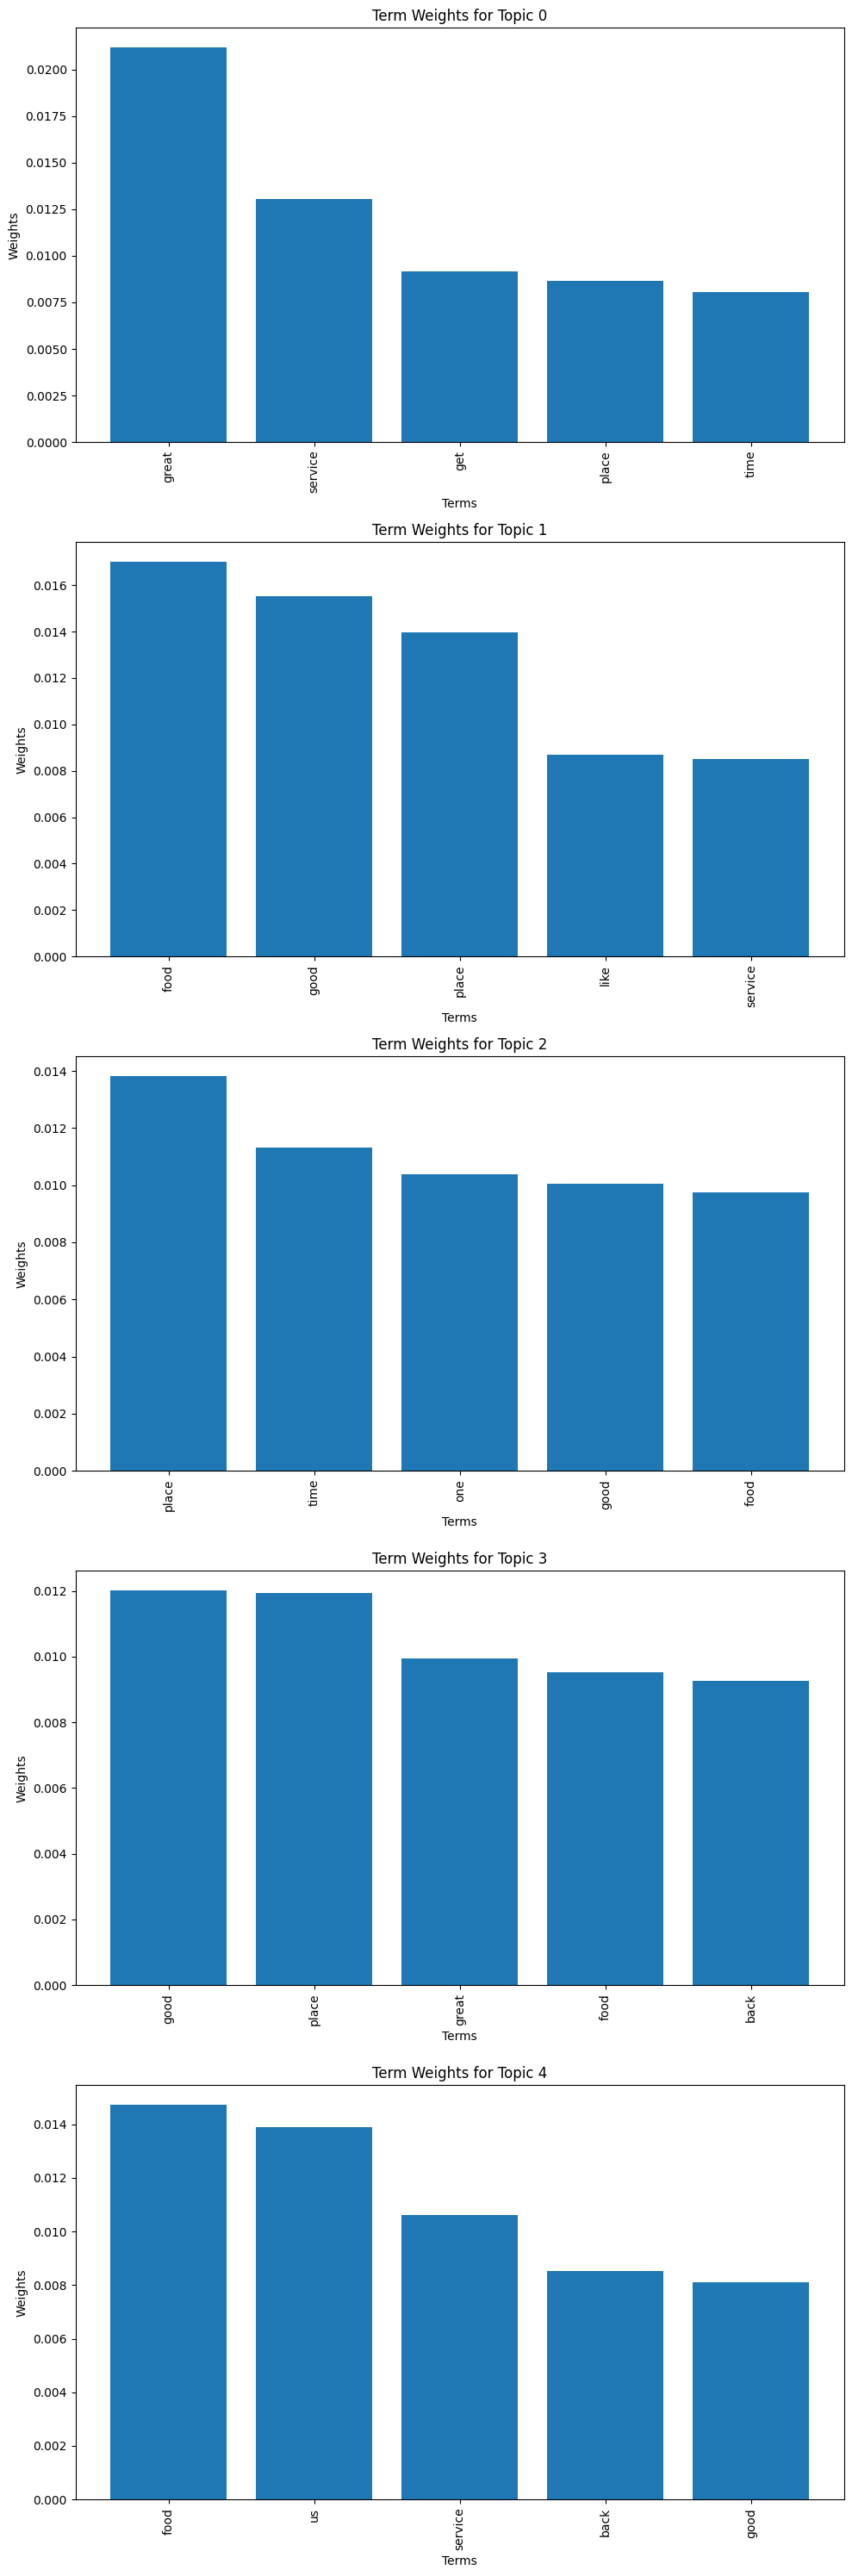

In [ ]:
import matplotlib.pyplot as plt

def plot_topics(topics_words, num_topics_to_plot):
    # Set the number of rows and columns for the subplots
    nrows = num_topics_to_plot
    ncols = 1

    # Create a figure and array of subplots with 1 column and 'num_topics_to_plot' rows.
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6 * nrows))

    # Check if there's only one subplot to avoid indexing errors
    if num_topics_to_plot == 1:
        axes = [axes]

    # Plot each topic in its own subplot
    for idx, (topic, words, weights) in enumerate(topics_words[:num_topics_to_plot]):
        ax = axes[idx]
        ax.bar(words, weights)
        ax.set_xlabel('Terms')
        ax.set_ylabel('Weights')
        ax.set_title(f'Term Weights for Topic {topic}')
        ax.tick_params(axis='x', rotation=90)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Let's plot the first 5 topics
num_topics_to_plot = 5
plot_topics(topics_words, num_topics_to_plot)


#### LDA Analysis Non-Elite Users

In [ ]:
# Filter the data based on elite_flag

df_non_elite = df_transformed.filter(df_transformed.elite_flag == 0).sample(withReplacement=False, fraction=0.04)

# Fit LDA models to elite and non-elite user reviews

model_non_elite = lda.fit(df_non_elite)



AttributeError: 'RDD' object has no attribute 'show'

In [ ]:
# Display topics

topics_non_elite = model_non_elite.describeTopics(maxTermsPerTopic=5)


topics_non_elite.show(truncate=False)


+-----+----------------+--------------------------------------------------------------------------------------------------------------+
|topic|termIndices     |termWeights                                                                                                   |
+-----+----------------+--------------------------------------------------------------------------------------------------------------+
|0    |[3, 4, 7, 1, 6] |[0.021183167068409448, 0.013060896305661922, 0.009158171640671382, 0.00865977551874654, 0.008059055630937942] |
|1    |[0, 2, 1, 5, 4] |[0.017001470543459178, 0.015516060754285455, 0.013967901071960172, 0.008705783837012517, 0.008511866440793577]|
|2    |[1, 6, 8, 2, 0] |[0.013814093174871759, 0.011310005154197353, 0.01037020330089643, 0.01004330543696809, 0.009734523916746703]  |
|3    |[2, 1, 3, 0, 9] |[0.012007661620986201, 0.011925185475331347, 0.009950509813542962, 0.009532821043590049, 0.009253887706099896]|
|4    |[0, 15, 4, 9, 2]|[0.014724930499191023, 0

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

vocabulary = vocab_rdd.collect()

# Define a function to map term indices to words using the collected vocabulary
def map_term_indices_to_words(term_indices):
    return [vocabulary[int(index)] for index in term_indices]

# Convert DataFrame to RDD, apply the function, and collect results
topics_words = topics_non_elite.rdd.map(lambda row: (row['topic'], map_term_indices_to_words(row['termIndices']), row['termWeights'])).collect()

# Display the topics with the words and their corresponding weights
for topic, words, weights in topics_words:
    print(f"Topic {topic}:")
    for word, weight in zip(words, weights):
        print(f"\t{word}: {weight}")

Topic 0:
	great: 0.021183167068409448
	service: 0.013060896305661922
	get: 0.009158171640671382
	place: 0.00865977551874654
	time: 0.008059055630937942
Topic 1:
	food: 0.017001470543459178
	good: 0.015516060754285455
	place: 0.013967901071960172
	like: 0.008705783837012517
	service: 0.008511866440793577
Topic 2:
	place: 0.013814093174871759
	time: 0.011310005154197353
	one: 0.01037020330089643
	good: 0.01004330543696809
	food: 0.009734523916746703
Topic 3:
	good: 0.012007661620986201
	place: 0.011925185475331347
	great: 0.009950509813542962
	food: 0.009532821043590049
	back: 0.009253887706099896
Topic 4:
	food: 0.014724930499191023
	us: 0.013904427885391531
	service: 0.010612752603455126
	back: 0.00851297862173175
	good: 0.00809483337860517


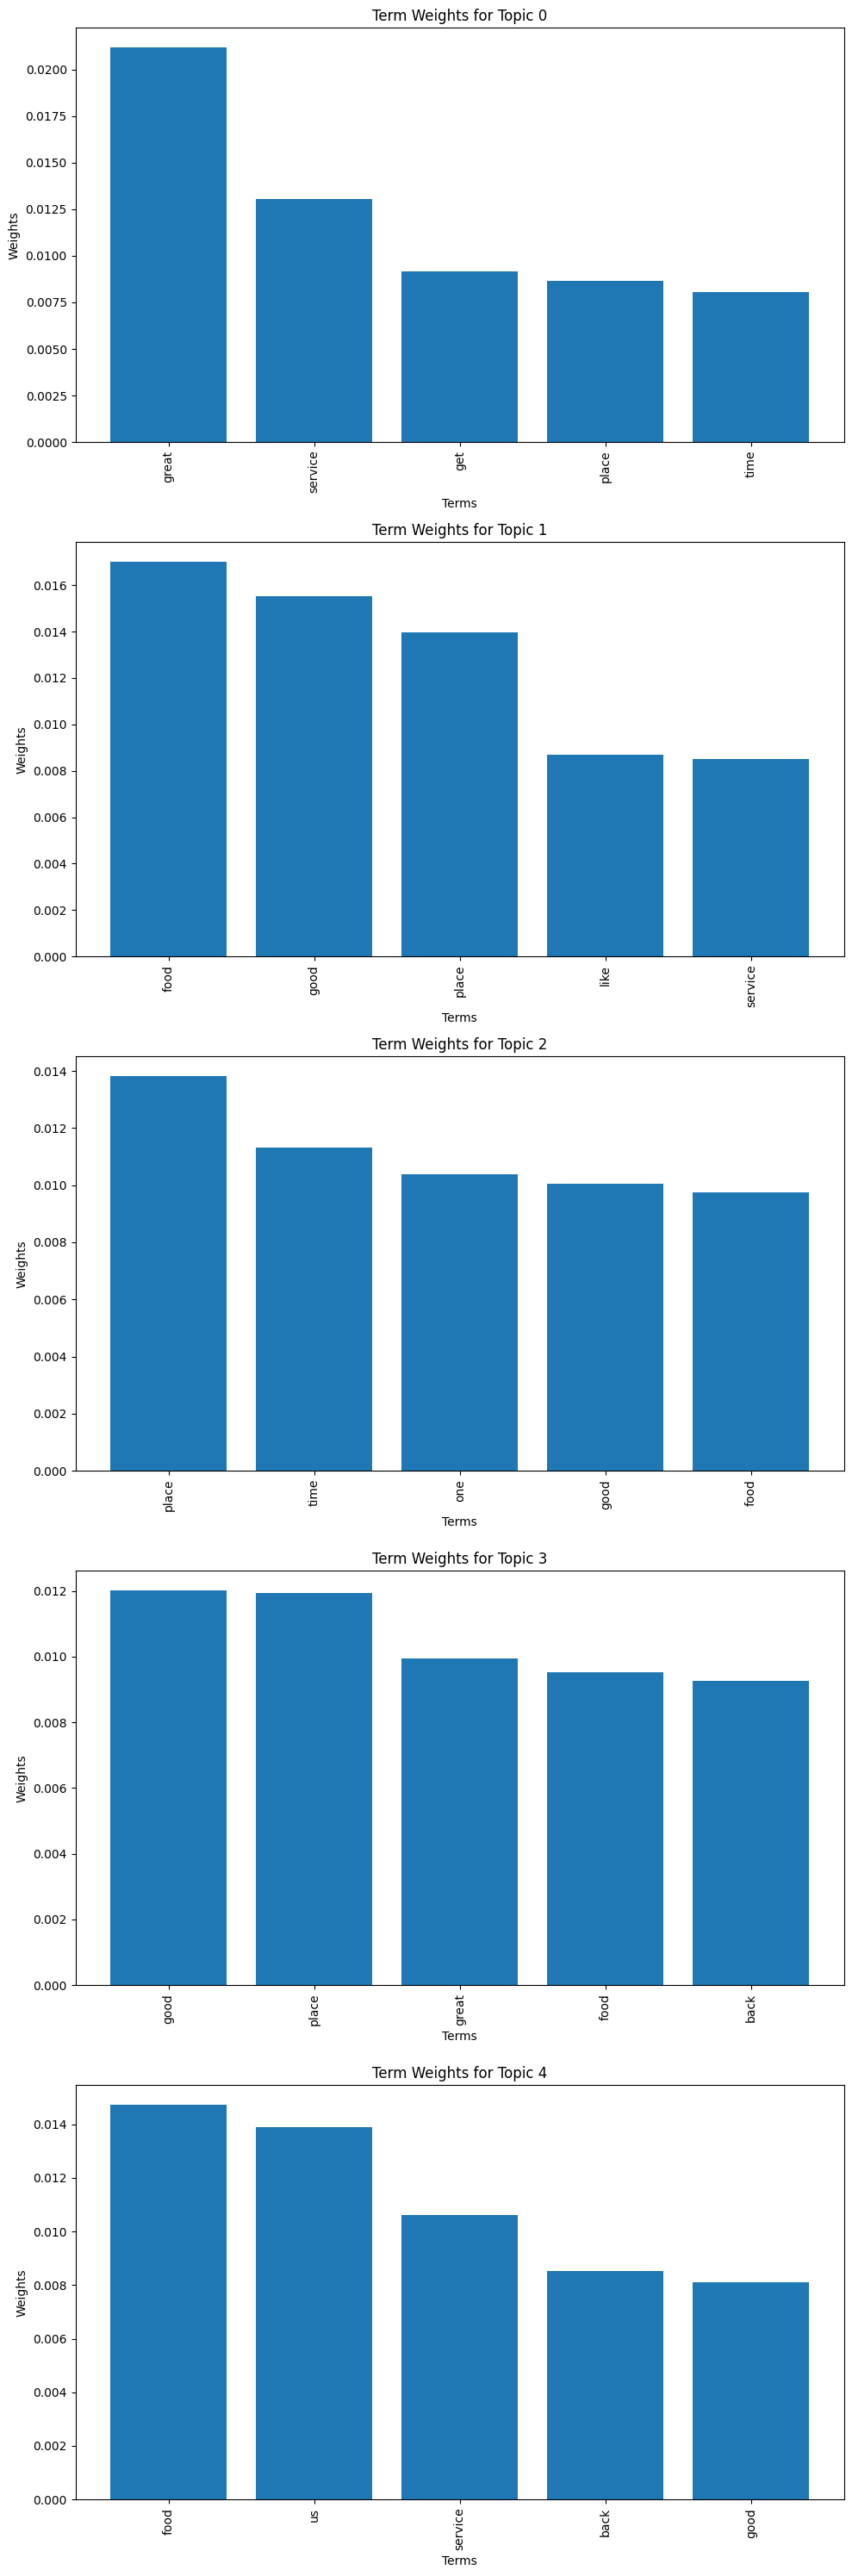

In [ ]:
import matplotlib.pyplot as plt

def plot_topics(topics_words, num_topics_to_plot):
    # Set the number of rows and columns for the subplots
    nrows = num_topics_to_plot
    ncols = 1

    # Create a figure and array of subplots with 1 column and 'num_topics_to_plot' rows.
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6 * nrows))

    # Check if there's only one subplot to avoid indexing errors
    if num_topics_to_plot == 1:
        axes = [axes]

    # Plot each topic in its own subplot
    for idx, (topic, words, weights) in enumerate(topics_words[:num_topics_to_plot]):
        ax = axes[idx]
        ax.bar(words, weights)
        ax.set_xlabel('Terms')
        ax.set_ylabel('Weights')
        ax.set_title(f'Term Weights for Topic {topic}')
        ax.tick_params(axis='x', rotation=90)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Let's plot the first 5 topics
num_topics_to_plot = 5
plot_topics(topics_words, num_topics_to_plot)
